<a href="https://colab.research.google.com/github/Riky2014/NAPDE/blob/main/cerchi_sensitivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [18]:
%%capture

!pip install -U "monai-weekly[fire, nibabel, yaml, tqdm, einops]"
!pip install GPUtil
from GPUtil import showUtilization as gpu_usage
gpu_usage()

# Mount Drive

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import and set directory

In [40]:
import os
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import monai
import numpy as np
from glob import glob
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism
from nibabel import load, save, Nifti1Image

import torch
import logging
import sys
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
from monai.data import create_test_image_2d, list_data_collate, decollate_batch, DataLoader
from monai.visualize import plot_2d_or_3d_image




directory_path = '/content/drive/MyDrive/prova_cerchi_dir'
os.environ["MONAI_DATA_DIRECTORY"] = directory_path
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

# Function definition

In [41]:
def create_image_2d (n_train, n_test, noise, r_min, r_max):

  for i in range(n_train + n_test):
    image, label = create_test_image_2d(128, 128, num_seg_classes = 1, noise_max = noise, rad_min = r_min, rad_max = r_max)
    Image.fromarray((image * 255).astype("uint8")).save(os.path.join(root_dir, f"image{i:d}.png"))
    Image.fromarray((label * 255).astype("uint8")).save(os.path.join(root_dir, f"label{i:d}.png"))

  set_determinism(seed=0)

  images = sorted(glob(os.path.join(root_dir, "image*.png")))
  labels = sorted(glob(os.path.join(root_dir, "label*.png")))
  train_files = [{"image": image, "label": label} for image, label in zip(images[:n_train], labels[:n_train])]
  val_files = [{"image": image, "label": label} for image, label in zip(images[-n_test:], labels[-n_test:])]

  return train_files, val_files

In [42]:
def transform(train_files, val_files):
  train_transform = Compose(
  [
      LoadImaged(keys=["image", "label"]),
      EnsureChannelFirstd(keys=["image","label"]),
      EnsureTyped(keys=["image", "label"]),
      Orientationd(keys=["image", "label"], axcodes="RA"),
      Spacingd(
          keys=["image", "label"],
          pixdim=(1.0, 1.0),
          mode=("bilinear", "nearest"),
      ),
      RandSpatialCropd(keys=["image", "label"], roi_size=[128, 128], random_size=False),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      NormalizeIntensityd(keys="label", divisor= 255.0),
      RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
      RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
  ]
  )

  val_transform = Compose(
  [
      LoadImaged(keys=["image", "label"]),
      EnsureChannelFirstd(keys=["image","label"]),
      EnsureTyped(keys=["image", "label"]),
      Orientationd(keys=["image", "label"], axcodes="RA"),
      Spacingd(
          keys=["image", "label"],
          pixdim=(1.0, 1.0),
          mode=("bilinear", "nearest"),
      ),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      NormalizeIntensityd(keys="label", divisor= 255.0),
  ]
  )

  train_ds = monai.data.Dataset(data=train_files, transform=train_transform)
  train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)

  val_ds = monai.data.Dataset(data=val_files, transform=val_transform)
  val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

  return train_loader, val_loader, val_ds

In [43]:
def model_and_train(train_loader, val_loader, max_epochs, val_ds):
  val_interval = 1
  VAL_AMP = True

  # standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
  device = torch.device("cuda:0")
  model = SegResNet(
    spatial_dims = 2,
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=1,
    out_channels=1,
    dropout_prob=0.2,
  ).to(device)

  loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
  optimizer = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-7)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

  dice_metric = DiceMetric(include_background=True, reduction="mean")
  dice_metric_train = DiceMetric(include_background=False, reduction="mean")

  post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

  # define the inference method
  def inference(input):
      def _compute(input):
          return sliding_window_inference(
              inputs=input,
              roi_size=(128, 128),
              sw_batch_size=1,
              predictor=model,
              overlap=0.5,
          )

      if VAL_AMP:
          with torch.cuda.amp.autocast():
              return _compute(input)
      else:
          return _compute(input)

  # use "amp" to accelerate training
  scaler = torch.cuda.amp.GradScaler()
  # enable "cuDNN benchmark"
  torch.backends.cudnn.benchmark = True


  best_metric = -1
  best_metric_epoch = -1
  best_metrics_epochs_and_time = [[], [], []]
  epoch_loss_values = []
  metric_values = []
  metric_values_train = []

  total_start = time.time()

  for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = ( batch_data["image"].to(device), batch_data["label"].to(device) )
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

        outputs = [post_trans(i) for i in decollate_batch(outputs)]
        labels = [post_trans(i) for i in decollate_batch(labels)]
        dice_metric_train(y_pred=outputs, y=labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

    metric_train = dice_metric_train.aggregate().item()
    metric_values_train.append(metric_train)
    dice_metric_train.reset()

    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Loss: {epoch_loss:.4f}"
          f"\nTrain dice: {metric_train:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )

                val_outputs = model(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_trans(i) for i in decollate_batch(val_labels)]

                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                #print("saved new best metric model")

            print(
                f"Test dice: {metric:.4f}")
            """
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}")
            """

    print(f"Time: {(time.time() - epoch_start):.4f}")
    total_time = time.time() - total_start
  print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

  print()
  print(f"Train metric = {metric_values_train[-1]}, Test metric = {metric_values[-1]}")
  print()
  print()

  model.eval()
  with torch.no_grad():
    i = 0

    val_input = val_ds[i]["image"].unsqueeze(0).to(device)

    val_outputs = model(val_input) # default: overlap = 0.25 (vs 0.5)
    val_outputs = post_trans(val_outputs[0])

    plt.figure("fig")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.set_title(f"{i} - image")
    ax1.imshow(val_ds[i]["image"][0, :, :].detach().cpu(), cmap="gray")

    ax2.set_title(f"{i} - label")
    ax2.imshow(val_ds[i]["label"][0, :, :].detach().cpu())

    ax3.set_title(f"{i} - output")
    ax3.imshow(val_outputs[0, :, :].detach().cpu())
    plt.show()

  return metric_values_train[-1], metric_values[-1], epoch_loss_values[-1]

In [54]:
def plot_graph(n_train_vec, metric_train, metric_test, loss, r_min, r_max, noise, max_epochs):
  fig, ax = plt.subplots(1, 2, figsize = (12,6))

  plt.subplot(1,2,1)
  plt.plot(n_train_vec, metric_train, label = 'Train metric')
  plt.plot(n_train_vec, metric_test, label = 'Test metric')

  plt.xscale('log', base = 2)
  plt.legend()
  plt.title(f"noise = {noise}, epochs = {max_epochs}, r = ({r_min}, {r_max})")

  plt.subplot(1,2,2)
  plt.plot(n_train_vec, loss, label = 'Train loss')
  plt.xscale('log', base = 2)
  plt.legend()
  plt.title(f"noise = {noise}, epochs = {max_epochs}, r = ({r_min}, {r_max})")

In [49]:
def delete_image(directory_path):
  file_list = os.listdir(directory_path)
  for file in file_list:
      file_path = os.path.join(directory_path, file)
      if os.path.isfile(file_path):
          os.remove(file_path)
      elif os.path.isdir(file_path):
          os.rmdir(file_path)

  print()

# Execute training
Specify:
- minimum radius ("r_min": int)
- maximum radius ("r_max": int)
- noise to be added ("noise": float)
- training epochs ("max_epochs": int)


Number of training images = 8
Number of testing images = 40

----------
epoch 1/15
Loss: 0.8744
Train dice: 0.3878
Test dice: 0.8292
time consuming of epoch 1 is: 3.9348
----------
epoch 2/15
Loss: 0.6057
Train dice: 0.8233
Test dice: 0.8712
time consuming of epoch 2 is: 3.2871
----------
epoch 3/15
Loss: 0.5282
Train dice: 0.8748
Test dice: 0.8729
time consuming of epoch 3 is: 3.1580
----------
epoch 4/15
Loss: 0.4802
Train dice: 0.9012
Test dice: 0.9228
time consuming of epoch 4 is: 4.0018
----------
epoch 5/15
Loss: 0.4387
Train dice: 0.9201
Test dice: 0.9292
time consuming of epoch 5 is: 3.7535
----------
epoch 6/15
Loss: 0.4076
Train dice: 0.9333
Test dice: 0.9380
time consuming of epoch 6 is: 3.1926
----------
epoch 7/15
Loss: 0.3884
Train dice: 0.9273
Test dice: 0.9374
time consuming of epoch 7 is: 3.0656
----------
epoch 8/15
Loss: 0.3689
Train dice: 0.9276
Test dice: 0.9361
time consuming of epoch 8 is: 4.0551
----------
epoch 9/15
Loss: 0.3552
Train dice: 0.9379
Test dice: 0

<Figure size 640x480 with 0 Axes>

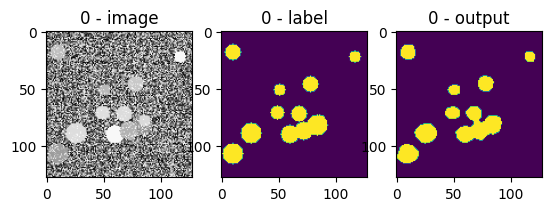



Number of training images = 16
Number of testing images = 40

----------
epoch 1/15
Loss: 0.7447
Train dice: 0.6244
Test dice: 0.8442
time consuming of epoch 1 is: 4.6627
----------
epoch 2/15
Loss: 0.5039
Train dice: 0.8844
Test dice: 0.9276
time consuming of epoch 2 is: 3.9547
----------
epoch 3/15
Loss: 0.4183
Train dice: 0.9222
Test dice: 0.9408
time consuming of epoch 3 is: 4.1379
----------
epoch 4/15
Loss: 0.3603
Train dice: 0.9333
Test dice: 0.9427
time consuming of epoch 4 is: 4.7628
----------
epoch 5/15
Loss: 0.3182
Train dice: 0.9337
Test dice: 0.9436
time consuming of epoch 5 is: 3.9872
----------
epoch 6/15
Loss: 0.2828
Train dice: 0.9405
Test dice: 0.9425
time consuming of epoch 6 is: 3.7104
----------
epoch 7/15
Loss: 0.2564
Train dice: 0.9437
Test dice: 0.9478
time consuming of epoch 7 is: 5.1023
----------
epoch 8/15
Loss: 0.2370
Train dice: 0.9473
Test dice: 0.9493
time consuming of epoch 8 is: 4.0118
----------
epoch 9/15
Loss: 0.2244
Train dice: 0.9469
Test dice:

<Figure size 640x480 with 0 Axes>

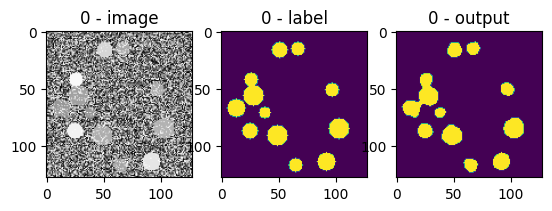



Number of training images = 32
Number of testing images = 40

----------
epoch 1/15
Loss: 0.6258
Train dice: 0.7539
Test dice: 0.9239
time consuming of epoch 1 is: 7.7584
----------
epoch 2/15
Loss: 0.3826
Train dice: 0.9278
Test dice: 0.9377
time consuming of epoch 2 is: 5.3347
----------
epoch 3/15
Loss: 0.2851
Train dice: 0.9415
Test dice: 0.9432
time consuming of epoch 3 is: 6.5135
----------
epoch 4/15
Loss: 0.2278
Train dice: 0.9453
Test dice: 0.9425
time consuming of epoch 4 is: 5.0588
----------
epoch 5/15
Loss: 0.1931
Train dice: 0.9465
Test dice: 0.9481
time consuming of epoch 5 is: 5.6143
----------
epoch 6/15
Loss: 0.1741
Train dice: 0.9455
Test dice: 0.9490
time consuming of epoch 6 is: 6.0440
----------
epoch 7/15
Loss: 0.1565
Train dice: 0.9500
Test dice: 0.9545
time consuming of epoch 7 is: 5.0426
----------
epoch 8/15
Loss: 0.1451
Train dice: 0.9534
Test dice: 0.9523
time consuming of epoch 8 is: 6.5501
----------
epoch 9/15
Loss: 0.1388
Train dice: 0.9544
Test dice:

<Figure size 640x480 with 0 Axes>

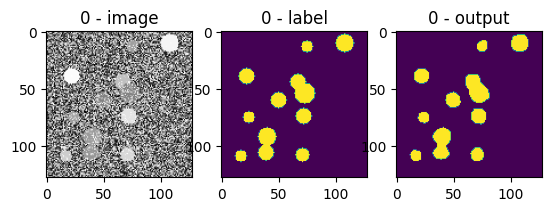



Number of training images = 64
Number of testing images = 40

----------
epoch 1/15
Loss: 0.5031
Train dice: 0.8432
Test dice: 0.9410
time consuming of epoch 1 is: 7.9600
----------
epoch 2/15
Loss: 0.2567
Train dice: 0.9419
Test dice: 0.9443
time consuming of epoch 2 is: 8.8729
----------
epoch 3/15
Loss: 0.1769
Train dice: 0.9487
Test dice: 0.9522
time consuming of epoch 3 is: 9.1432
----------
epoch 4/15
Loss: 0.1439
Train dice: 0.9511
Test dice: 0.9452
time consuming of epoch 4 is: 7.7031
----------
epoch 5/15
Loss: 0.1270
Train dice: 0.9539
Test dice: 0.9569
time consuming of epoch 5 is: 9.1474
----------
epoch 6/15
Loss: 0.1170
Train dice: 0.9566
Test dice: 0.9588
time consuming of epoch 6 is: 9.2993
----------
epoch 7/15
Loss: 0.1097
Train dice: 0.9592
Test dice: 0.9563
time consuming of epoch 7 is: 7.7719
----------
epoch 8/15
Loss: 0.1051
Train dice: 0.9606
Test dice: 0.9661
time consuming of epoch 8 is: 9.1481
----------
epoch 9/15
Loss: 0.1013
Train dice: 0.9630


In [ ]:
n_train_vec  = [8, 16, 32, 64, 128, 256]
n_test = 40

noise = 1.0
r_min = 5
r_max = 10

max_epochs = 15

metric_values_train_vec = []
metric_values_vec = []
epoch_loss_values_vec = []


for n_train in n_train_vec:
  print()
  print(f"Number of training images = {n_train}")
  print(f"Number of testing images = {n_test}")
  print()

  train_files, val_files = create_image_2d(n_train, n_test, noise, r_min, r_max)
  train_loader, val_loader, val_ds = transform(train_files, val_files)

  metric_value_train, metric_value, epoch_loss_value = model_and_train(train_loader, val_loader, max_epochs, val_ds)

  metric_values_train_vec.append(metric_value_train)
  metric_values_vec.append(metric_value)
  epoch_loss_values_vec.append(epoch_loss_value)

  delete_image(directory_path)

# Plot train and test metrics

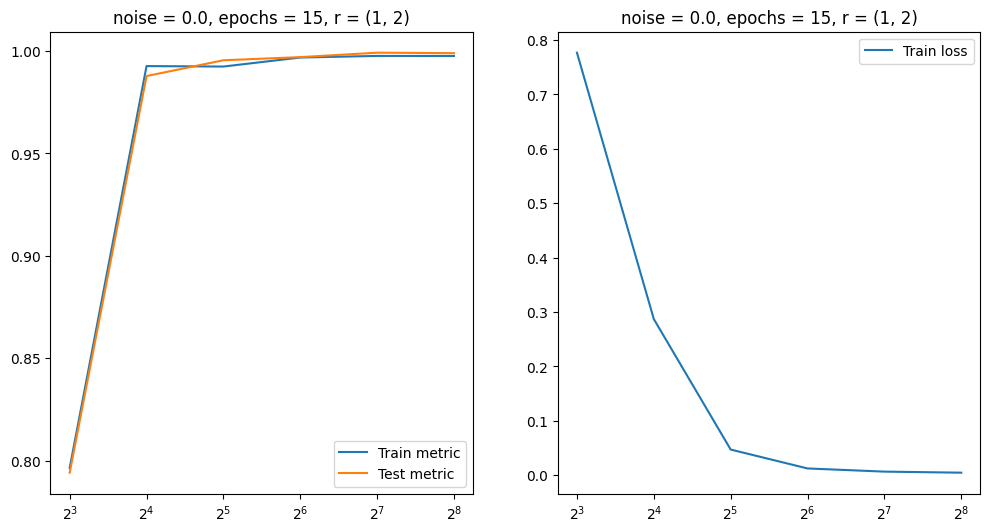

In [55]:
plot_graph(n_train_vec, metric_values_train_vec, metric_values_vec, epoch_loss_values_vec, r_min, r_max, noise, max_epochs)